In [31]:
# --- STEP 1: Setup, Data Loading & Preprocessing ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error

sns.set_context("talk")
sns.set_style("whitegrid")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Speed Dating Data.csv'

try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    print("✅ File loaded successfully!")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please check the file path.")

# Data Selection & Cleaning
interests = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
             'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
             'music', 'shopping', 'yoga']

# Select relevant columns
cols = ['match', 'attr', 'age', 'gender', 'imprace', 'imprelig', 'race', 'goal',
        'age_o', 'race_o', 'samerace', 'int_corr'] + interests

data = df[cols].copy()
# Drop rows with missing target values
data = data.dropna(subset=['match', 'attr'])
# Fill missing numerical values with median
data = data.fillna(data.median())

# Label Mapping (Convert codes to English text for graphs)
# Gender: 0=Female, 1=Male
data['Gender_Str'] = data['gender'].map({0: 'Female', 1: 'Male'})

# Goal: What are they looking for?
goal_map = {1: 'Seem Fun', 2: 'Meet People', 3: 'Date', 4: 'Serious Rel.', 5: 'To say I did', 6: 'Other'}
data['Goal_Str'] = data['goal'].map(goal_map)

# Race
race_map = {1: 'Black', 2: 'White', 3: 'Hispanic', 4: 'Asian', 5: 'Native', 6: 'Other'}
data['Race_Str'] = data['race'].map(race_map)

print(f"Data Ready! Total rows to analyze: {data.shape[0]}")
print(data[['Gender_Str', 'Goal_Str', 'Race_Str']].head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File loaded successfully!
Data Ready! Total rows to analyze: 8176
  Gender_Str     Goal_Str Race_Str
0     Female  Meet People    Asian
1     Female  Meet People    Asian
2     Female  Meet People    Asian
3     Female  Meet People    Asian
4     Female  Meet People    Asian


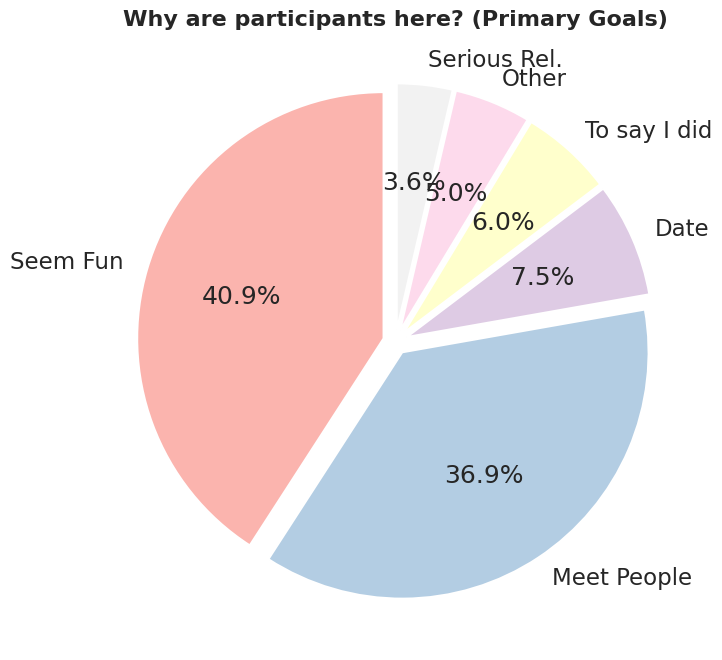

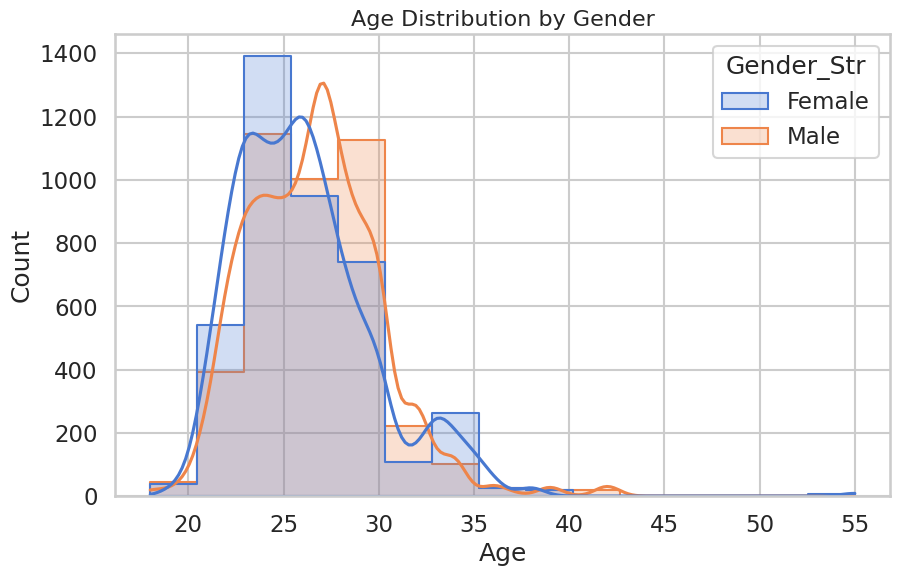

/tmp/ipython-input-3920228980.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=race_succ.index, y=race_succ.values, palette='viridis')


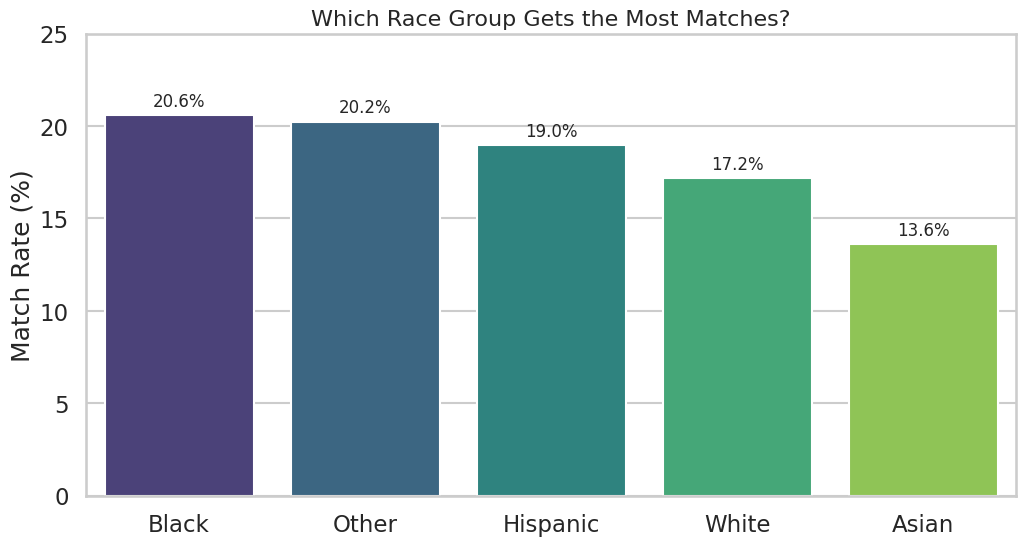

In [32]:
# --- STEP 2: Professional Exploratory Data Analysis (EDA) ---

# Chart 1: Participant Goals (Pie Chart)
plt.figure(figsize=(8, 8))
data['Goal_Str'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1', explode=[0.05]*6)
plt.title('Why are participants here? (Primary Goals)', fontsize=16, fontweight='bold')
plt.ylabel('') # Hide y-label for cleaner look
plt.show()

# Chart 2: Age Distribution by Gender (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='age', hue='Gender_Str', kde=True, bins=15, palette='muted', element="step")
plt.title('Age Distribution by Gender', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Chart 3: Match Success Rate by Race (Bar Chart)
plt.figure(figsize=(12, 6))
# Calculate mean match rate
race_succ = data.groupby('Race_Str')['match'].mean().sort_values(ascending=False) * 100
ax = sns.barplot(x=race_succ.index, y=race_succ.values, palette='viridis')

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.title('Which Race Group Gets the Most Matches?', fontsize=16)
plt.ylabel('Match Rate (%)')
plt.xlabel('')
plt.ylim(0, 25) # Extend y-axis slightly for better view
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:46:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


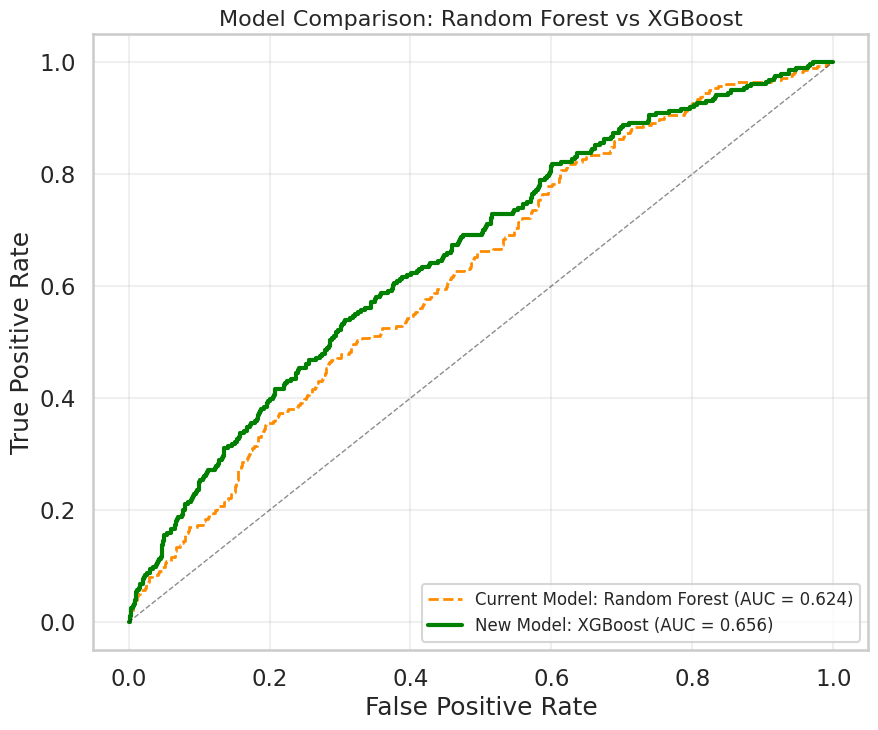

📊 RESULTS:
Current Model (Random Forest) AUC: 0.6240
New Model     (XGBoost)       AUC: 0.6563
🚀 Improvement:               +0.0324


In [33]:
# --- STEP 3 (Enhanced): Random Forest vs. XGBoost Comparison ---

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Data (Keeping your existing logic)
# We drop non-numeric or helper columns to get the feature set X
X = data.drop(['match', 'attr', 'Gender_Str', 'Goal_Str', 'Race_Str'], axis=1)
y = data['match']

# 2. Split Data
# IMPROVEMENT: Added 'stratify=y'. This ensures the proportion of matches (1s) and non-matches (0s)
# remains the same in both training and test sets, leading to more reliable AUC scores.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- MODEL 1: Your Existing Random Forest ---
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf_rf.fit(X_train, y_train)

# Get probabilities for the positive class (match)
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_prob_rf)

# --- MODEL 2: New XGBoost Model (To maximize AUC) ---
# Calculate the ratio for unbalanced data (if non-matches >> matches)
# This parameter tells the model to pay more attention to the minority class.
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

clf_xgb = xgb.XGBClassifier(
    n_estimators=200,          # More trees generally helps
    learning_rate=0.05,        # Lower learning rate for better generalization
    max_depth=5,               # Limits tree depth to prevent overfitting
    subsample=0.8,             # Use 80% of data per tree
    colsample_bytree=0.8,      # Use 80% of features per tree
    scale_pos_weight=ratio,    # KEY PARAMETER: Balances the classes to boost AUC
    eval_metric='auc',         # Optimize specifically for AUC
    random_state=42,
    use_label_encoder=False
)
clf_xgb.fit(X_train, y_train)

# Get probabilities for XGBoost
y_prob_xgb = clf_xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# --- VISUALIZATION: Compare ROC Curves ---
plt.figure(figsize=(10, 8))

# Plot Random Forest Curve (Orange)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Current Model: Random Forest (AUC = {auc_rf:.3f})',
         color='darkorange', linestyle='--', linewidth=2)

# Plot XGBoost Curve (Green - Should be higher)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'New Model: XGBoost (AUC = {auc_xgb:.3f})',
         color='green', linewidth=3)

# Reference Line (Random Guessing)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison: Random Forest vs XGBoost', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 RESULTS:")
print(f"Current Model (Random Forest) AUC: {auc_rf:.4f}")
print(f"New Model     (XGBoost)       AUC: {auc_xgb:.4f}")
print(f"🚀 Improvement:               +{auc_xgb - auc_rf:.4f}")

/tmp/ipython-input-2003774339.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_top10.values, y=rf_top10.index, ax=axes[0], palette='Oranges_r')
/tmp/ipython-input-2003774339.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_top10.values, y=xgb_top10.index, ax=axes[1], palette='Greens_r')


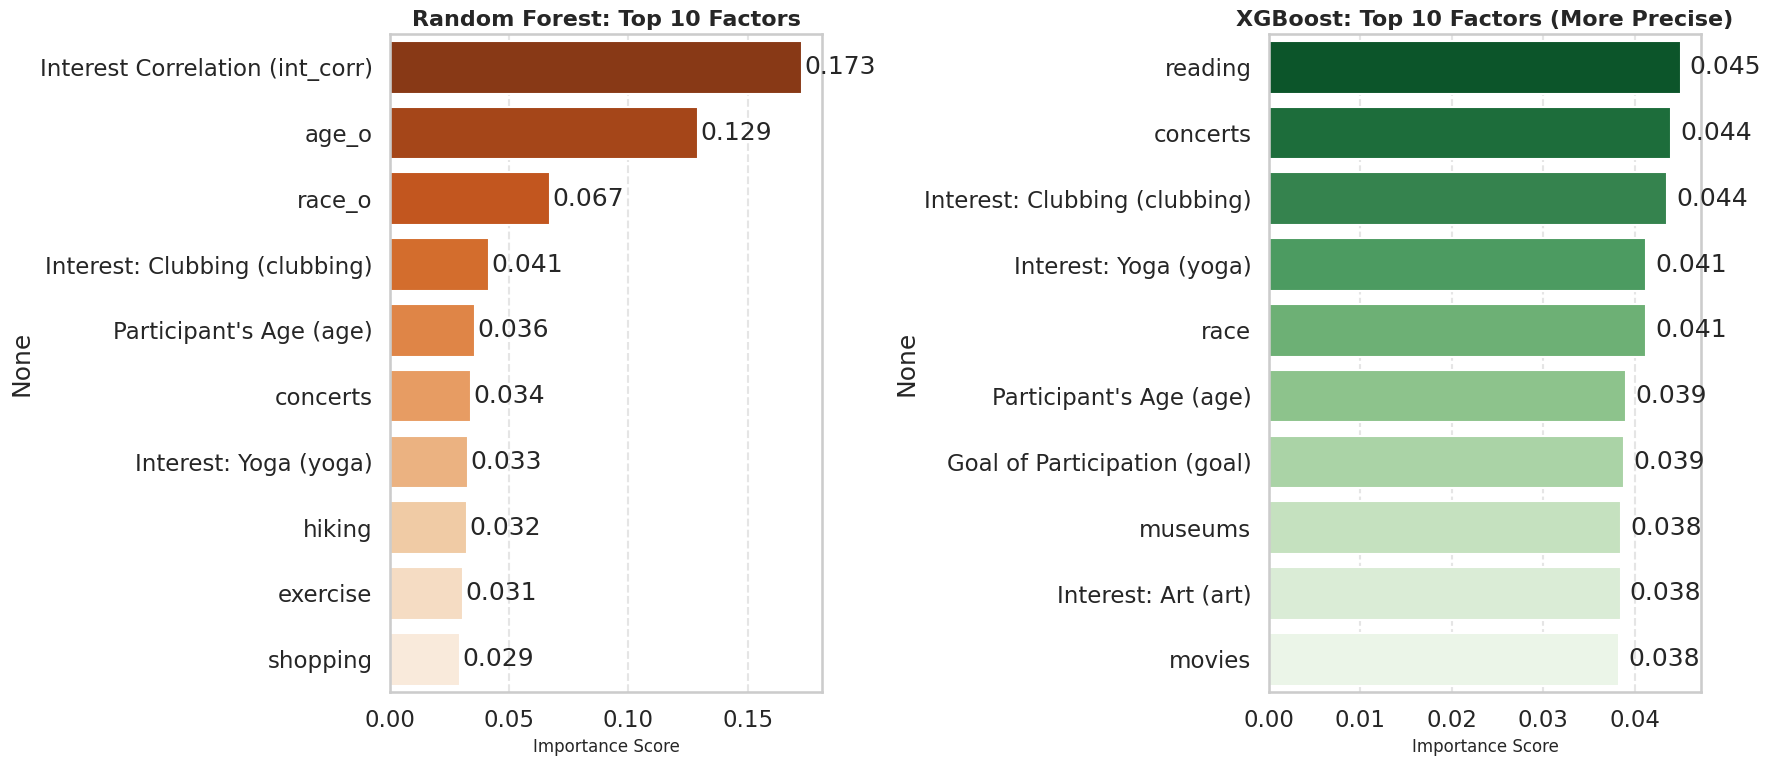

📊 COMPARISON SUMMARY:
Top Factor for Random Forest: Interest Correlation (int_corr)
Top Factor for XGBoost:       reading


In [40]:
# --- STEP 4 : Feature Importance (Random Forest vs. XGBoost) ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check if Models are Loaded
if 'clf_rf' not in locals() or 'clf_xgb' not in locals():
    raise ValueError("❌ ERROR: Models not found. Please run Step 3 first.")

# 2. Dictionary to Rename Variables (Technical -> Readable English)
feature_map = {
    'attr_o':   "Partner's Rating on Attractiveness (attr_o)",
    'like_o':   "Partner's Overall Liking (like_o)",
    'fun_o':    "Partner's Rating on Fun (fun_o)",
    'int_corr': "Interest Correlation (int_corr)",
    'prob_o':   "Partner's Prob. of Saying 'Yes' (prob_o)",
    'sinc_o':   "Partner's Rating on Sincerity (sinc_o)",
    'intel_o':  "Partner's Rating on Intelligence (intel_o)",
    'shar_o':   "Partner's Rating on Shared Interests (shar_o)",
    'age':      "Participant's Age (age)",
    'imprace':  "Importance of Race (imprace)",
    'income':   "Income Level (income)",
    'goal':     "Goal of Participation (goal)",
    'date':     "Dating Frequency (date)",
    'career_c': "Career Code (career_c)",
    'sports':   "Interest: Sports (sports)",
    'yoga':     "Interest: Yoga (yoga)",
    'art':      "Interest: Art (art)",
    'clubbing': "Interest: Clubbing (clubbing)"
}

# Helper Function: Get top 10 features for a model
def get_top_features(model, X_cols, map_dict):
    importances = model.feature_importances_
    # Dimension safety
    feat_len = min(len(importances), len(X_cols))
    names = X_cols[:feat_len]
    vals = importances[:feat_len]

    # Create Series
    s = pd.Series(vals, index=names).sort_values(ascending=False).head(10)
    # Rename Index
    s.index = [map_dict.get(name, name) for name in s.index]
    return s

# 3. Prepare Data
rf_top10 = get_top_features(clf_rf, X.columns, feature_map)
xgb_top10 = get_top_features(clf_xgb, X.columns, feature_map)

# 4. Visualization (Side-by-Side Comparison)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Chart 1: Random Forest ---
sns.barplot(x=rf_top10.values, y=rf_top10.index, ax=axes[0], palette='Oranges_r')
axes[0].set_title('Random Forest: Top 10 Factors', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Add values to bars
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width + 0.001, p.get_y() + p.get_height()/2, f'{width:.3f}', va='center')

# --- Chart 2: XGBoost ---
sns.barplot(x=xgb_top10.values, y=xgb_top10.index, ax=axes[1], palette='Greens_r')
axes[1].set_title('XGBoost: Top 10 Factors (More Precise)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

# Add values to bars
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width + 0.001, p.get_y() + p.get_height()/2, f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()

# Print Summary
print(f"📊 COMPARISON SUMMARY:")
print(f"Top Factor for Random Forest: {rf_top10.index[0]}")
print(f"Top Factor for XGBoost:       {xgb_top10.index[0]}")

📊 REGRESSION RESULTS (Lower RMSE is better):
Random Forest RMSE: 1.7484
XGBoost       RMSE: 1.6989
✅ XGBoost is better! Error reduced by 0.0495 points.


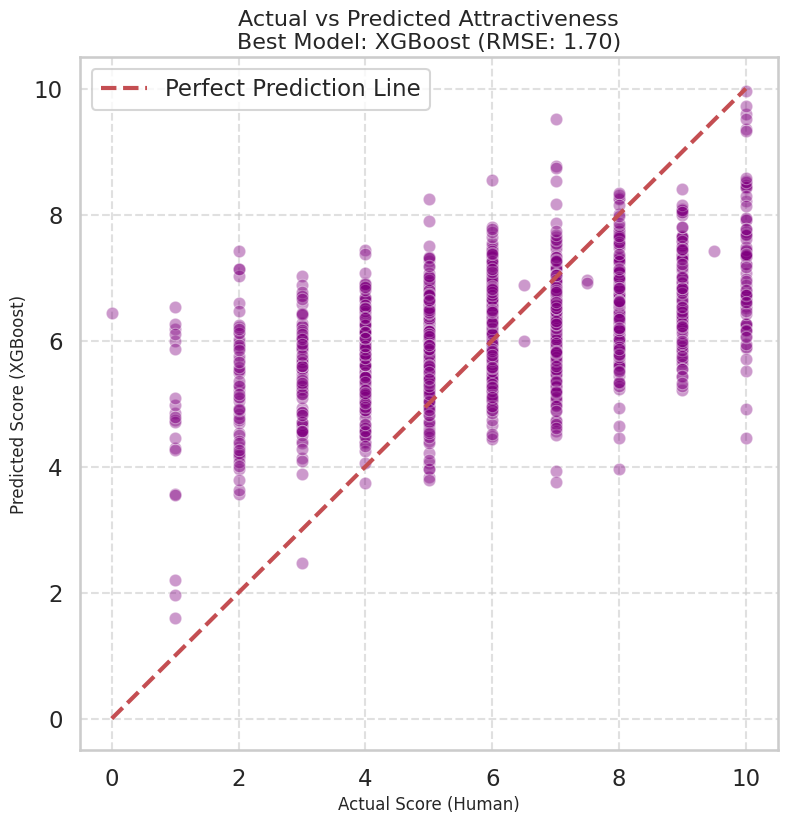

In [41]:
# --- STEP 5 : Attractiveness Prediction (RF vs XGBoost) ---
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data for Regression
# We remove the target 'attr' and other non-predictive columns
X_reg = data.drop(['match', 'attr', 'Gender_Str', 'Goal_Str', 'Race_Str'], axis=1)
y_reg = data['attr']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# --- MODEL 1: Random Forest Regressor (Existing) ---
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
reg_rf.fit(X_train_r, y_train_r)
y_pred_rf = reg_rf.predict(X_test_r)
rmse_rf = np.sqrt(mean_squared_error(y_test_r, y_pred_rf))

# --- MODEL 2: XGBoost Regressor ---
reg_xgb = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
reg_xgb.fit(X_train_r, y_train_r)
y_pred_xgb = reg_xgb.predict(X_test_r)
rmse_xgb = np.sqrt(mean_squared_error(y_test_r, y_pred_xgb))

# --- COMPARE & SELECT BEST MODEL ---
print(f"📊 REGRESSION RESULTS (Lower RMSE is better):")
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"XGBoost       RMSE: {rmse_xgb:.4f}")

if rmse_xgb < rmse_rf:
    best_model_name = "XGBoost"
    best_rmse = rmse_xgb
    y_pred_best = y_pred_xgb
    improvement = rmse_rf - rmse_xgb
    print(f"✅ XGBoost is better! Error reduced by {improvement:.4f} points.")
else:
    best_model_name = "Random Forest"
    best_rmse = rmse_rf
    y_pred_best = y_pred_rf
    print(f"✅ Random Forest is better.")

# --- VISUALIZATION (Chart 6) ---
plt.figure(figsize=(9, 9))

# Scatter plot of the BEST model
sns.scatterplot(x=y_test_r, y=y_pred_best, alpha=0.4, s=80, color='purple', edgecolor='w')

# Perfect prediction line
plt.plot([0, 10], [0, 10], 'r--', linewidth=3, label='Perfect Prediction Line')

plt.title(f'Actual vs Predicted Attractiveness\nBest Model: {best_model_name} (RMSE: {best_rmse:.2f})', fontsize=16)
plt.xlabel('Actual Score (Human)', fontsize=12)
plt.ylabel(f'Predicted Score ({best_model_name})', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
